<div style="text-align:center">
    <h1 style="font-size: 50px; margin-bottom: 0">Some nifty Python tools</h1>
    <h2 style="font-size: 20px; font-style:italic">ASTR 541 (Au 2022) - Final Project - Tom Wagg</h2>
    <p style="font-size:16px; text-align:center">For my final project I've created a series of python tools for helping to understand<br>the electron configuration of atoms and their spectroscopic terms.</p>
</div>

In [89]:
import astropy.units as u
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import configurations
import terms
import levels
import atom

In [90]:
from importlib import reload

# Electronic Configuration
The first code product of my project is to create a function that returns the electronic configuration for a particular atom. I don't guarrantee that this will work for ions (since they can disobey the Aufbau principle) but I still allow you to compute it.

I have included all elements up to Krypton (mostly because there were lots of exceptions after that haha)

## Example calls
Here's how you can use the functions to compute the configurations and format them nicely. The algorithm for this is pretty simple and just fills subshells to capacity following the Aufbau principle.

### Directly from a number of electrons

In [73]:
ec_O = configurations.get_configuration(8)
print(f"An atom with 8 electrons have a configuration of {configurations.format_configuration(ec_O)}")

An atom with 8 electrons have a configuration of 1s2 2s2 2p4


### From an atom/ion name

In [91]:
n_electron, n_ion = configurations.parse_electrons("Iron")
ec_FeI = configurations.get_configuration(n_electron=n_electron, n_ion=n_ion)
print(f"Iron has a configuration of {configurations.format_configuration(ec_FeI)}")

n_electron, n_ion = configurations.parse_electrons("FeII")
ec_FeII = configurations.get_configuration(n_electron=n_electron, n_ion=n_ion)
print(f"Singly ionised iron has a configuration of {configurations.format_configuration(ec_FeII)}")

Iron has a configuration of 1s2 2s2 2p6 3s2 3p6 4s2 3d6
Singly ionised iron has a configuration of 1s2 2s2 2p6 3s2 3p6 3d6 4s1


You can also get it to return the values in LaTeX for pretty output

In [92]:
from IPython.display import display, Math
display(Math(configurations.format_configuration(ec_FeII, use_latex=True)))

<IPython.core.display.Math object>

### All configurations up to Krypton
Here's all of the configurations which I've confirmed are correct.

In [ ]:
for i in range(1, 37):
    print(i, ":", configurations.get_configuration(i, formatted=True))

1 : 1s1
2 : 1s2
3 : 1s2 2s1
4 : 1s2 2s2
5 : 1s2 2s2 2p1
6 : 1s2 2s2 2p2
7 : 1s2 2s2 2p3
8 : 1s2 2s2 2p4
9 : 1s2 2s2 2p5
10 : 1s2 2s2 2p6
11 : 1s2 2s2 2p6 3s1
12 : 1s2 2s2 2p6 3s2
13 : 1s2 2s2 2p6 3s2 3p1
14 : 1s2 2s2 2p6 3s2 3p2
15 : 1s2 2s2 2p6 3s2 3p3
16 : 1s2 2s2 2p6 3s2 3p4
17 : 1s2 2s2 2p6 3s2 3p5
18 : 1s2 2s2 2p6 3s2 3p6
19 : 1s2 2s2 2p6 3s2 3p6 4s1
20 : 1s2 2s2 2p6 3s2 3p6 4s2
21 : 1s2 2s2 2p6 3s2 3p6 4s2 3d1
22 : 1s2 2s2 2p6 3s2 3p6 4s2 3d2
23 : 1s2 2s2 2p6 3s2 3p6 4s2 3d3
24 : 1s2 2s2 2p6 3s2 3p6 4s1 3d5
25 : 1s2 2s2 2p6 3s2 3p6 4s2 3d5
26 : 1s2 2s2 2p6 3s2 3p6 4s2 3d6
27 : 1s2 2s2 2p6 3s2 3p6 4s2 3d7
28 : 1s2 2s2 2p6 3s2 3p6 4s2 3d8
29 : 1s2 2s2 2p6 3s2 3p6 4s1 3d10
30 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10
31 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10 4p1
32 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10 4p2
33 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10 4p3
34 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10 4p4
35 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10 4p5
36 : 1s2 2s2 2p6 3s2 3p6 4s2 3d10 4p6


# Spectroscopic Terms
The second code product of my project is to create a function that gives you a spectroscopic terms for a given $(n, l, n_e)$. This can be rather difficult to do by hand since it requires many combinations and large matrix manipulation. Luckily computers are good at that!

## Algorithm

The inputs for this algorithm are: the quantum numbers of the subshell being filled, $n$ and $l$, and the total number of electrons in the partially filled shell, $N_e$. The format of each term will be
\begin{equation}
    \mathrm{term} = \,{}^{2 S + 1}\mathcal{L}_{J}^p
\end{equation}

1.  **States:** Work the possible states that an electron can take (all pairings of $m_l$ and $m_s$ where $m_l \in [-l, l]$, $m_s \in [-\frac{1}{2}, \frac{1}{2}]$)
2.  **Combinations:** List *every* possible combination of size $N_e$ of these states that satisfies the Pauli exclusion principle (each electron has a unique pairing of $m_l$ and $m_s$). Yes, this is indeed rather a hassle by hand! BUT is trivial in Python! :D
3.  **Build matrix:** Given a combination $\{(m_l, m_s)_i \ \forall i \in [1, N_e]\}$, let $M_l = \sum_{i = 1}^{N_e} m_{l, i}$ and $M_s = \sum_{i = 1}^{N_e} m_{l, i}$. Compute $M_l$ and $M_s$ for each combination and populate a matrix indexed on $M_l$ (rows) and $M_s$ (columns), where each entry is the total number of combinations resulting in that $(M_l, M_s)$ pairing.
4. **Reduce matrix:** While the matrix still has a nonzero entry
     - Find the row with the largest $M_l$ value with a nonzero entry - let the index of this row be $L$
     - Find the column \textit{within this row} with the largest $M_s$ value with a nonzero entry - let the index of this column be $S$
     - Store the pair $(L, S)$ as a possible term
     - Subtract a boolean matrix - ranging from the $(-L, L)$ rows and from the $(-S, S)$ columns - from the overall matrix
5. **Expand terms:** For each ($L, S$) pair, output a term for each $J$ in the range $[|L - S|, |L + S|]$
6. **Prevent mental breakdown:** Go get yourself a cookie, you deserve it after all of that!

Additionally, if we want to sort these in terms of energy then we can apply Hund's rules:
 - First sort descending by multiplicity, $(2 S + 1)$
 - Next sort descending by angular momentum, $L$
 - Next sort by angular momentum, $J$. If the shell is half-filled then sort ascending, otherwise descending

## Algorithm in action
I added a `stepbystep` parameter to the function call so that you can see it step through each of the steps I list in the algorithm and see what's going on behind the scenes.

In [ ]:
terms.get_spectroscopic_terms(3, 1, 3, stepbystep=True);

Step 1: Possible electron states (m_l, m_s)
-------------------------------------------
[(-1, -0.5), (-1, 0.5), (0, -0.5), (0, 0.5), (1, -0.5), (1, 0.5)]

Step 2: All possible combinations of states
-------------------------------------------
[((-1, -0.5), (-1, 0.5), (0, -0.5)), ((-1, -0.5), (-1, 0.5), (0, 0.5)), ((-1, -0.5), (-1, 0.5), (1, -0.5)), ((-1, -0.5), (-1, 0.5), (1, 0.5)), ((-1, -0.5), (0, -0.5), (0, 0.5)), ((-1, -0.5), (0, -0.5), (1, -0.5)), ((-1, -0.5), (0, -0.5), (1, 0.5)), ((-1, -0.5), (0, 0.5), (1, -0.5)), ((-1, -0.5), (0, 0.5), (1, 0.5)), ((-1, -0.5), (1, -0.5), (1, 0.5)), ((-1, 0.5), (0, -0.5), (0, 0.5)), ((-1, 0.5), (0, -0.5), (1, -0.5)), ((-1, 0.5), (0, -0.5), (1, 0.5)), ((-1, 0.5), (0, 0.5), (1, -0.5)), ((-1, 0.5), (0, 0.5), (1, 0.5)), ((-1, 0.5), (1, -0.5), (1, 0.5)), ((0, -0.5), (0, 0.5), (1, -0.5)), ((0, -0.5), (0, 0.5), (1, 0.5)), ((0, -0.5), (1, -0.5), (1, 0.5)), ((0, 0.5), (1, -0.5), (1, 0.5))]

Step 3: Initial matrix
----------------------
[[0 1 1 0]
 [0 2 2 

## Comparison to Draine results

Table 4.1 in Draine gives the terms in order of increasing energy for the $ns$ and $np$ subshells.

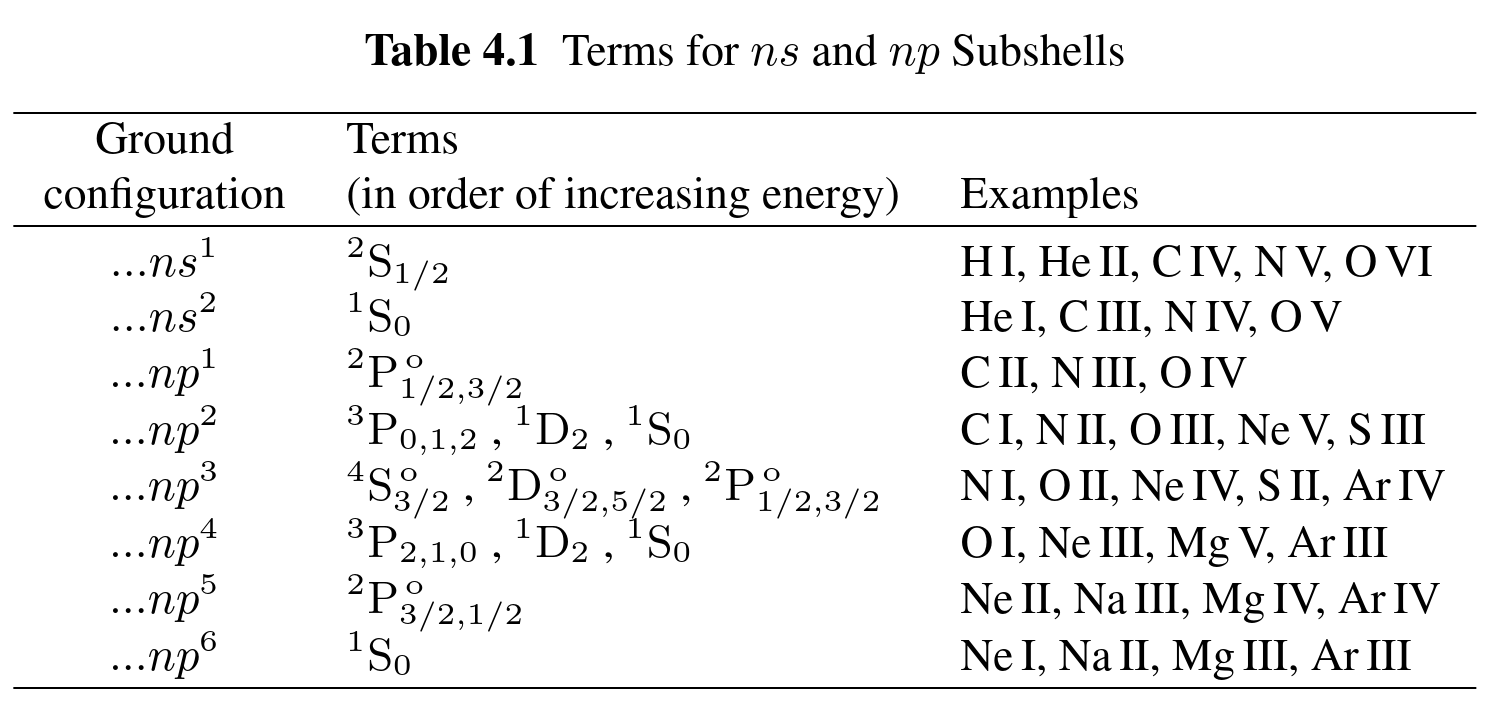

We can compute those *same* values and check that they match

In [ ]:
for ne in [1, 2]:
    print(*terms.format_terms(*terms.get_spectroscopic_terms(1, 0, ne)))
for ne in range(1, 7):
    print(*terms.format_terms(*terms.get_spectroscopic_terms(2, 1, ne)))

2S(1/2)
1S0
2P(1/2) 2P(3/2)
3P0 3P1 3P2 1D2 1S0
4S(3/2) 2D(3/2) 2D(5/2) 2P(1/2) 2P(3/2)
3P2 3P1 3P0 1D2 1S0
2P(3/2) 2P(1/2)
1S0


They match woop (note the flip in J order once you reach half-filled)!

# Energy Level Diagrams
The third and final code product of my project is energy level diagrams. Given a list of spectroscopic terms and a list of transitions I can create an energy level diagram. Each transition is of the form ($n_u, n_l, \lambda$), where $n_u$ is the upper level, $n_l$ is lower level and $\lambda$ is the wavelength of photon corresponding to the transition. A value of $n=1$ corresponds to the first term supplied.

## Simple example
Here's an imaginary energy level diagram just to demonstrate its usage. I'll show a more realistic version in the next section.

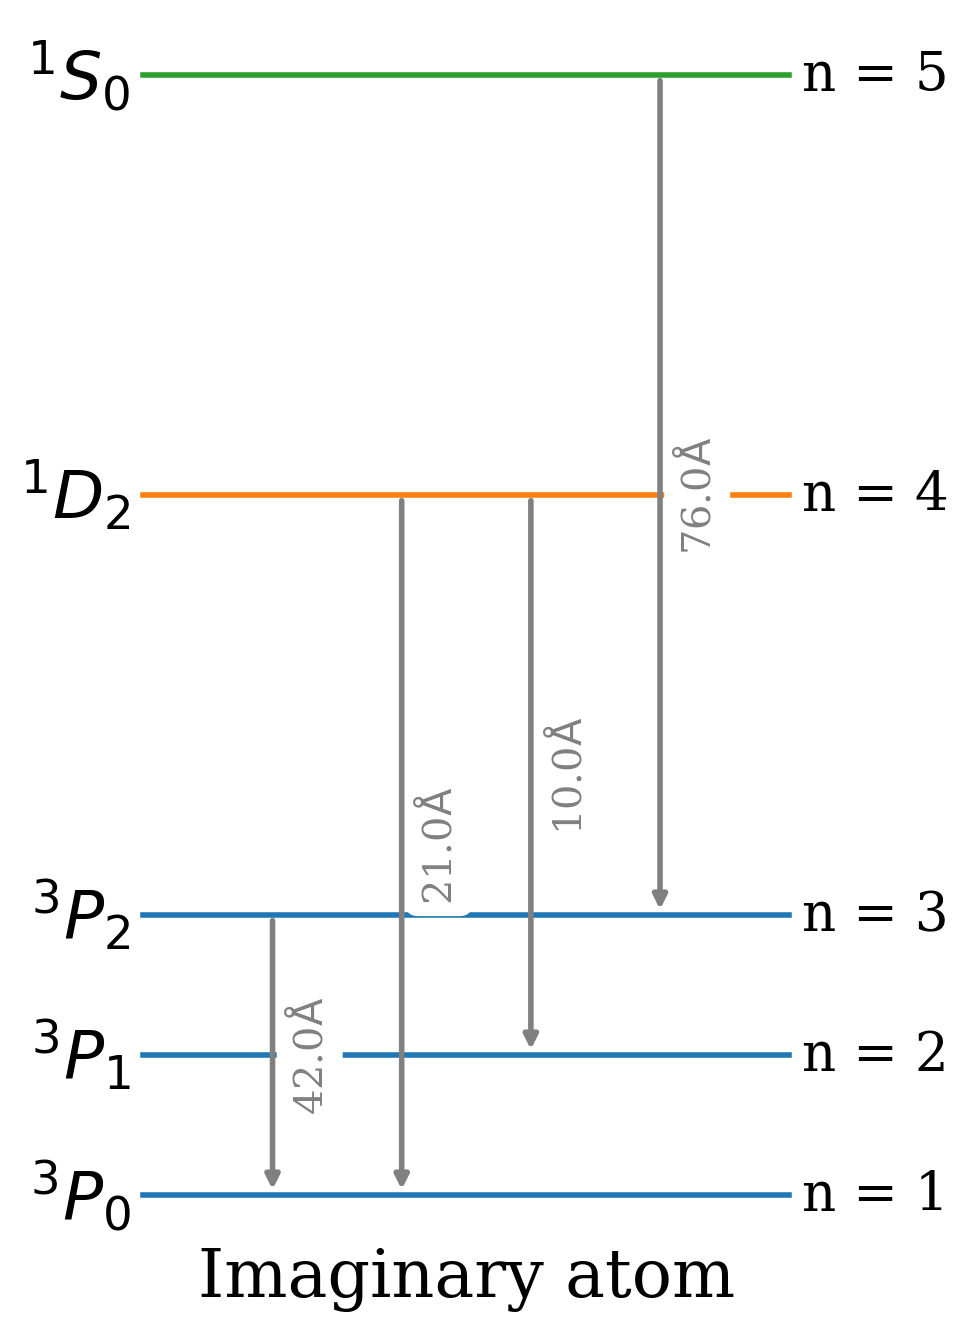

In [ ]:
levels.plot_energy_levels(terms.get_spectroscopic_terms(2, 1, 2),
                          [(3, 1, 42 * u.Angstrom),
                          (4, 2, 10 * u.Angstrom),
                          (4, 1, 21 * u.Angstrom),
                          (5, 3, 76 * u.Angstrom)],
                          title="Imaginary atom", figsize=(5, 8));

## Customised settings
You can also supply a pre-created figure, change the size of the figure and which labels are present.

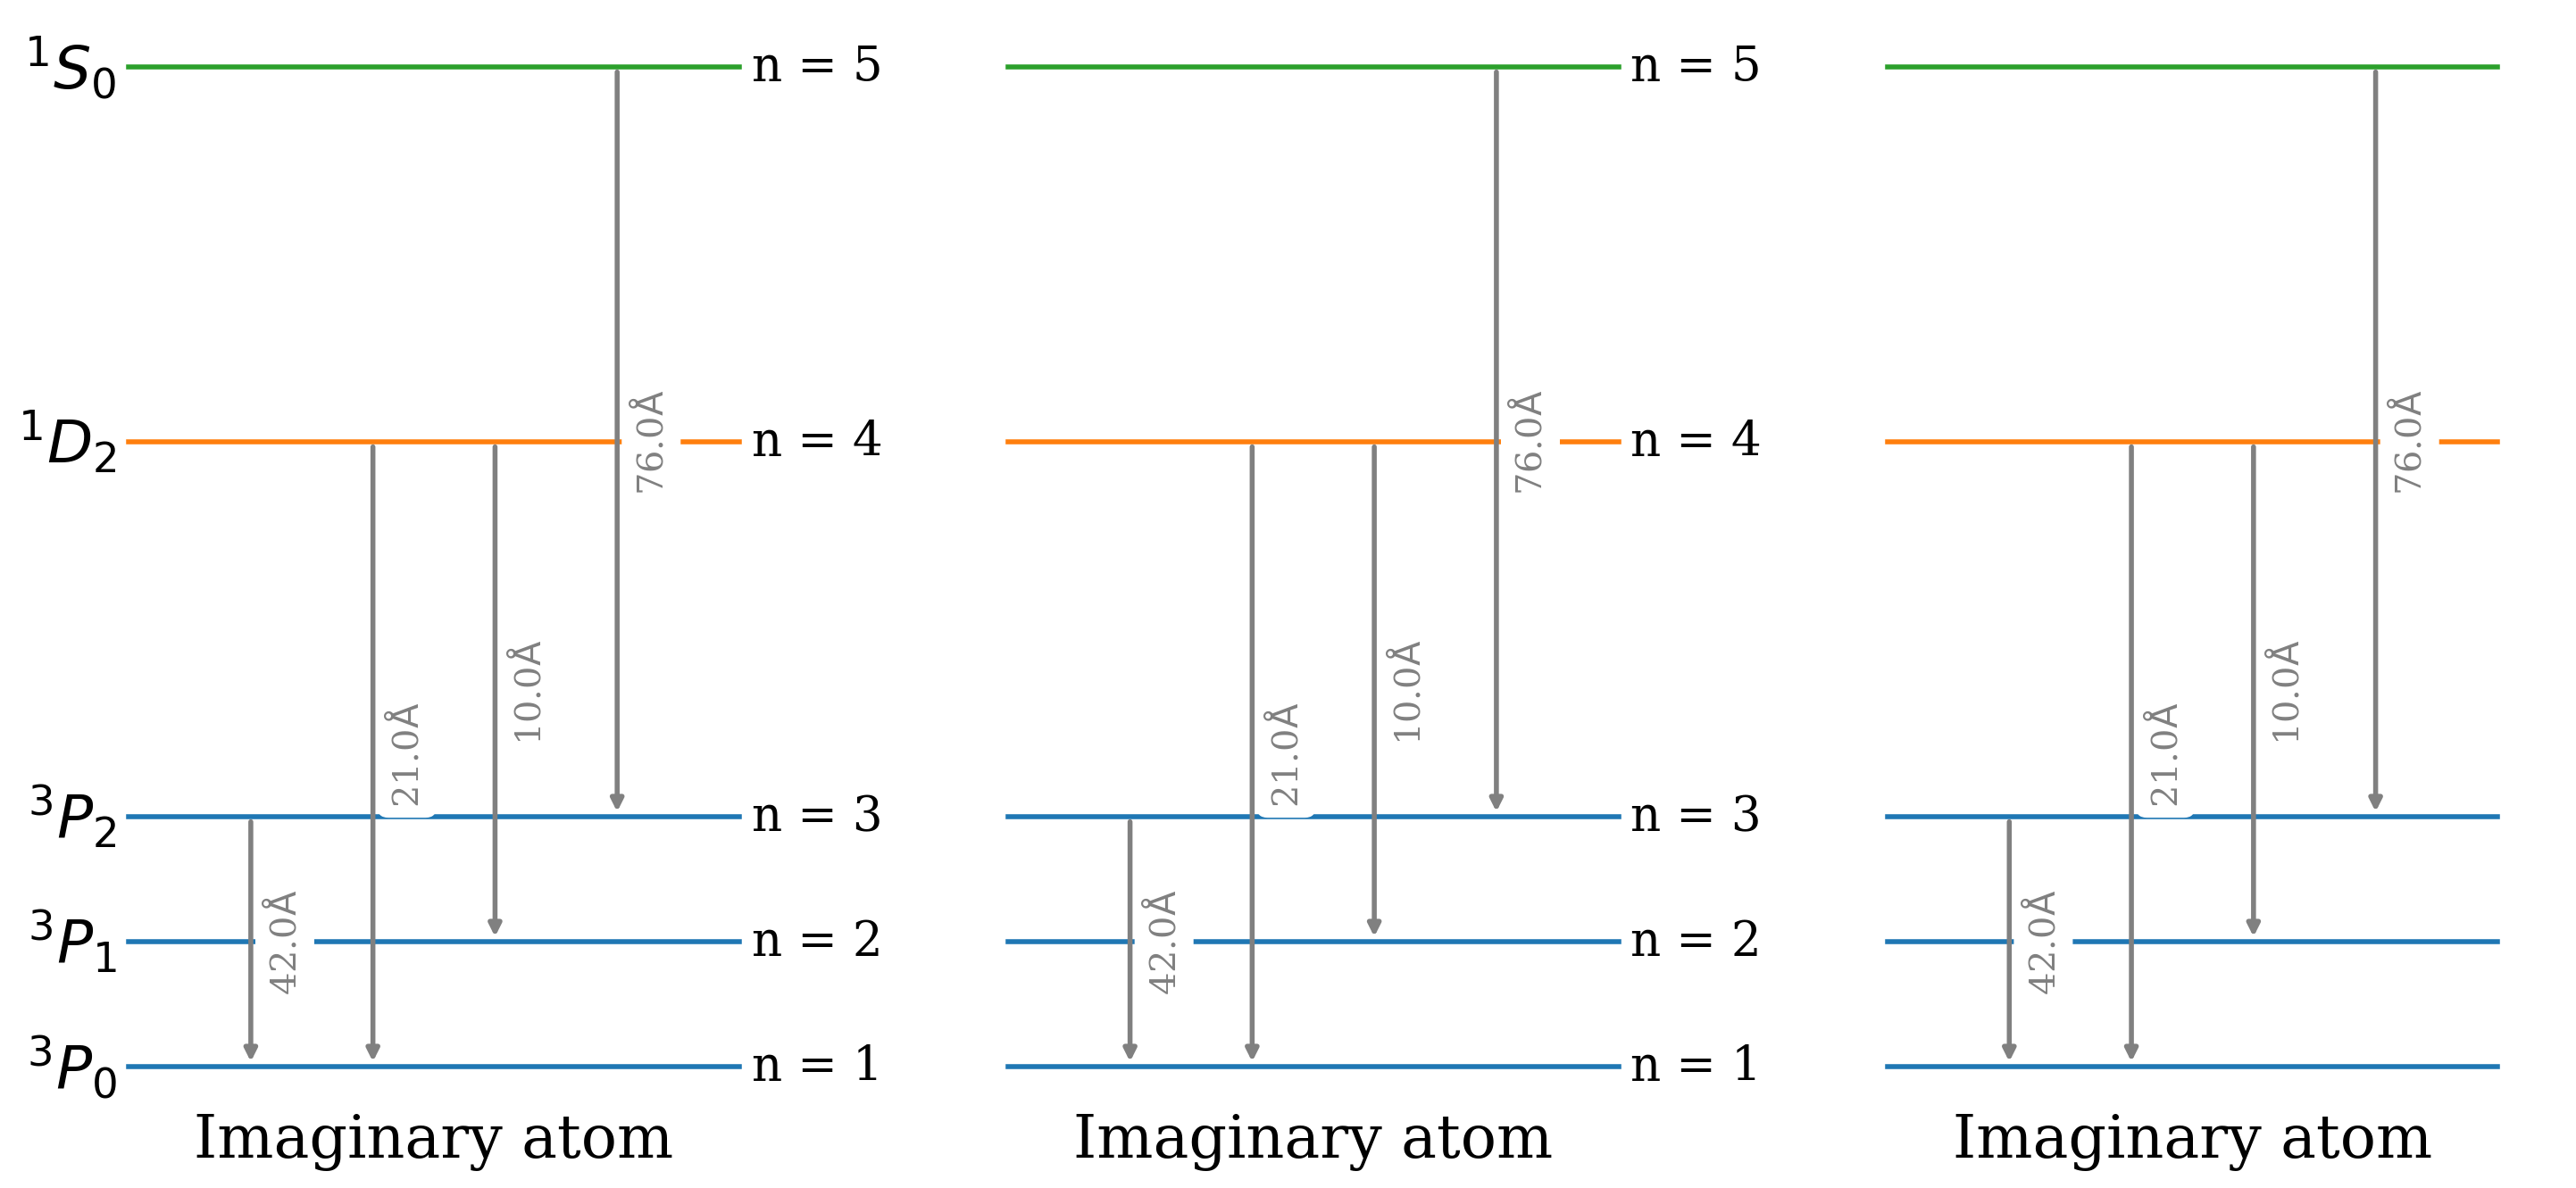

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
levels.plot_energy_levels(terms.get_spectroscopic_terms(2, 1, 2), [(3, 1, 42 * u.Angstrom),
                                                                   (4, 2, 10 * u.Angstrom),
                                                                   (4, 1, 21 * u.Angstrom),
                                                                   (5, 3, 76 * u.Angstrom)],
                          title="Imaginary atom", fig=fig, ax=axes[0], show=False)
levels.plot_energy_levels(terms.get_spectroscopic_terms(2, 1, 2), [(3, 1, 42 * u.Angstrom),
                                                                   (4, 2, 10 * u.Angstrom),
                                                                   (4, 1, 21 * u.Angstrom),
                                                                   (5, 3, 76 * u.Angstrom)],
                          title="Imaginary atom", fig=fig, ax=axes[1], show=False, show_term_labels=False)
levels.plot_energy_levels(terms.get_spectroscopic_terms(2, 1, 2), [(3, 1, 42 * u.Angstrom),
                                                                   (4, 2, 10 * u.Angstrom),
                                                                   (4, 1, 21 * u.Angstrom),
                                                                   (5, 3, 76 * u.Angstrom)],
                          title="Imaginary atom", fig=fig, ax=axes[2], show=False, show_term_labels=False, show_n_labels=False)
plt.show()

# Atom Class
Having made these things, I thought it would be nice to have a uniform interface to everything that is slightly easier to use. Enter Atom! From a single Python class you can get the configuration, terms and plot diagrams :D

You can instantiate an atom with either a number of electrons or a string (in the same way as with the configurations that I explained above).

In [87]:
reload(configurations)
reload(terms)
reload(levels)
reload(atom)
atom.Atom(n_electron=6, n_ion=1)

<Atom: (6 - 1) electrons, 1s2 2s2 2p1, 2P(3/2)>

In [42]:
import constants

In [88]:
reload(configurations)
reload(terms)
reload(levels)
reload(constants)
reload(atom)
atom.Atom(name="CII")

<Atom: CII, 1s2 2s2 2p1, 2P(3/2)>

As you can see, the electronic configuration and terms are automatically calculated (I only show the lowest energy term for brevit though). You can then store this class instance and get all of these values.

In [66]:
sII = atom.Atom(name="SII")

In [67]:
sII.configuration

'1s2 2s2 2p6 3s2 3p3'

In [68]:
sII.terms

['4S(3/2)', '2D(3/2)', '2D(5/2)', '2P(1/2)', '2P(3/2)']

We can also now plot a real energy level diagram using the transition wavelengths that we were given in the week 5 in-class problem.

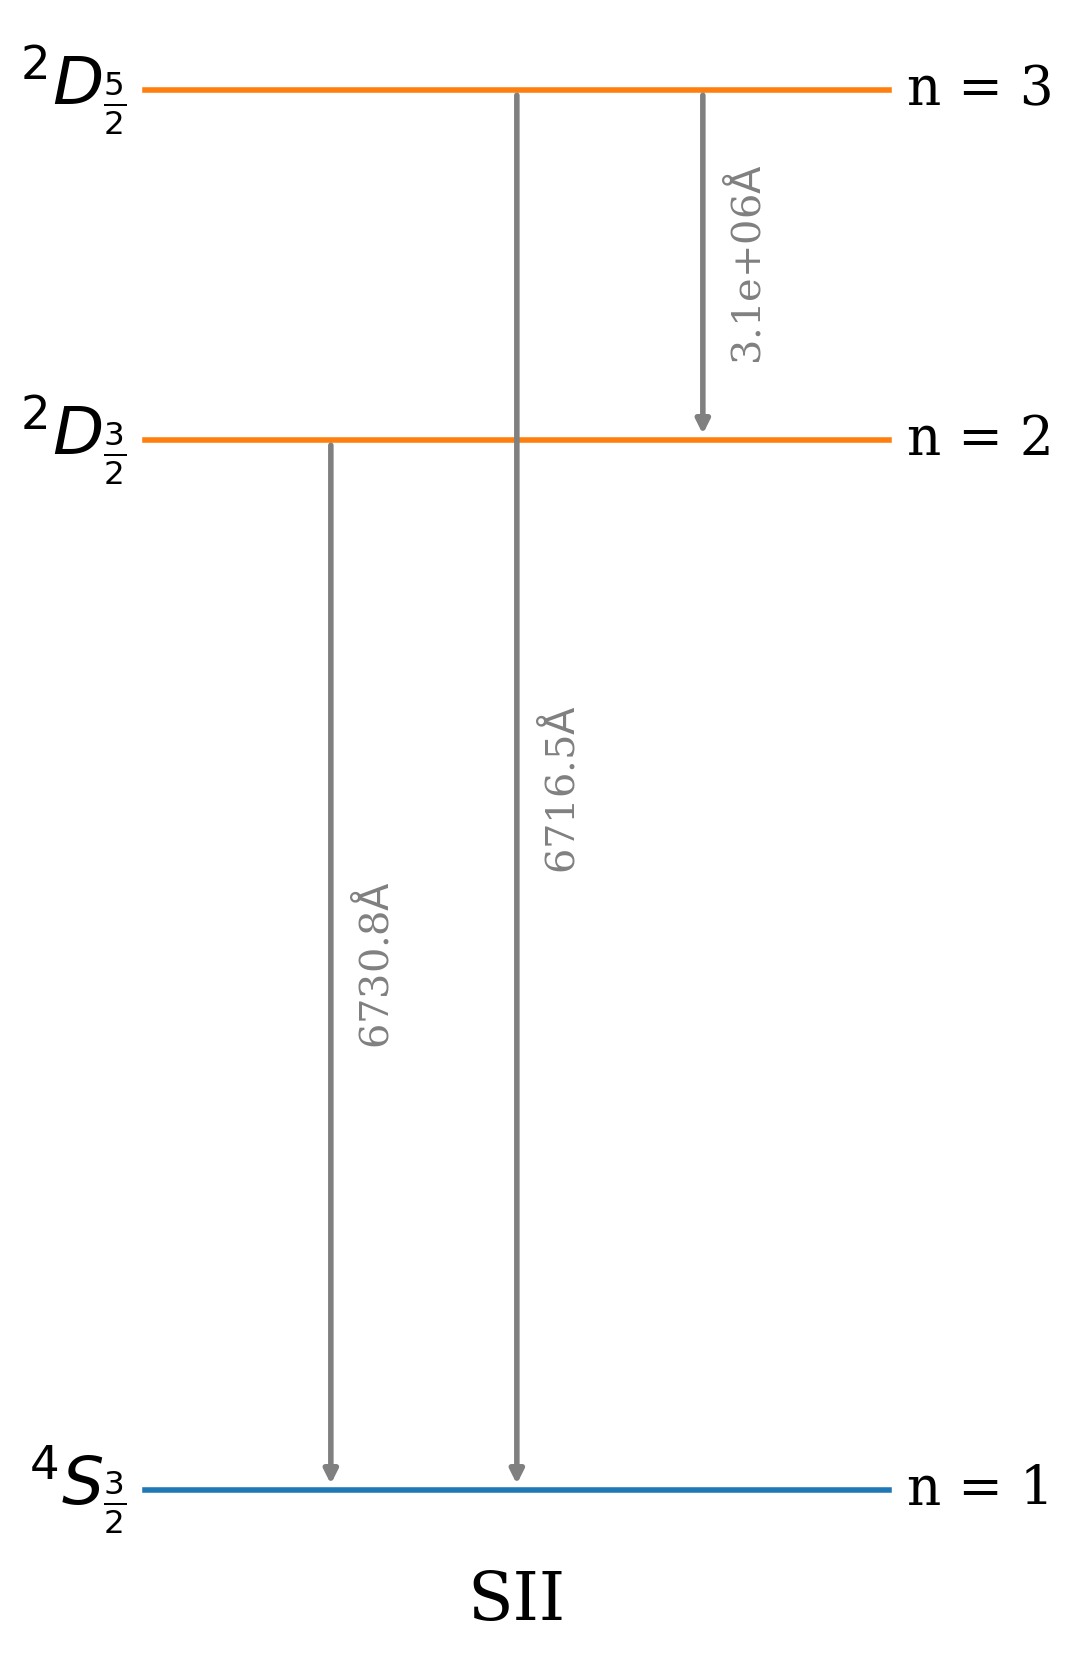

In [69]:
sII.plot_energy_levels(transitions=[(2, 1, 6730.8 * u.Angstrom),
                                    (3, 1, 6716.5 * u.Angstrom),
                                    (3, 2, 3.145e6 * u.Angstrom)]);